In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from mmf_speckle import *
from __init__ import *

In [3]:
import torch
import matplotlib.pyplot as plt
import h5py
from tqdm import tqdm
import numpy as np

In [4]:
device="cuda"
dtype=torch.float64
root="./results"

In [5]:
Width = 128
Height = 128
N = Width*Height
rate = 0.1526
M = int(N*rate)
print(M, N, N//M)

2500 16384 6


In [6]:
A_u = get_mmf_speckle_measure_matrix(25,device,dtype)

## Data Preparation

In [7]:
nosie_sigma = 0
nosie = nosie_sigma>0

In [8]:
# reconstruction of 7 unknown images
names=[
    "GI",
    "Baboon",
    "Peppers",
    "Goldhill",
    "Barbara",
    "Cameraman",
    "Lena"
]
y_uu_list = [] 
x_uu_list = []
for name in names:
    x_u = get_gi_image(0,device, dtype) if name=="GI" else get_t_image(name,device, dtype,W=Width,H=Height)
    y_u = speckle_measure(A_u, x_u.reshape((-1,1)), nosie=nosie, nosie_sigma=nosie_sigma) 
    y_uu_list.append(y_u)
    x_uu_list.append(x_u)

## Calibration

In [9]:
A = get_mmf_speckle_measure_matrix(0,device,dtype)

In [10]:
verbose=False

In [11]:
start = 0
end = 0
flag = True
A_recv = torch.zeros_like(A,device=device,dtype=dtype)
while flag:
    s = start*M
    if s+M>N:
        e = N
        flag = False
    else:
        e = s+M 
        
    # 部分基向量进行 重建矩阵    
    y_0_list = []
    y_u_list = []
    Y = torch.zeros(e-s,M,device=device,dtype=dtype)
    for i in tqdm(range(s,e)):
        x = torch.zeros((N,1),device=device,dtype=dtype)
        x[i] = 1
        y_0 = A @ x
        y_u = speckle_measure(A_u, x, nosie=nosie, nosie_sigma=nosie_sigma)  
        y_0_list.append(y_0)
        y_u_list.append(y_u)
        Y[i-s,:] = y_0.reshape((1,-1))
    
    L = torch.linalg.pinv(Y) @ torch.linalg.pinv(Y.T)
    if not flag and verbose:
        # 验证
        E = Y @ L @ Y.T
        print(E, torch.det(E))
    
    A_recv_k = torch.zeros_like(A,device=device,dtype=dtype)
    for i in tqdm(range(len(y_0_list))):
        A_recv_k += mismatch_equation(y_0_list[i], y_u_list[i], A, float64=True, _L=L)
    
    if not flag and verbose:
        print(A_recv_k[:,s:e] / A_u[:,s:e])
        
    A_recv[:,s:e] = A_recv_k[:,s:e]
    start+=1
    print("done")

100%|██████████| 2500/2500 [31:08<00:00,  1.34it/s]


done


100%|██████████| 2500/2500 [31:09<00:00,  1.34it/s]


done


100%|██████████| 2500/2500 [31:09<00:00,  1.34it/s]


done


100%|██████████| 2500/2500 [31:08<00:00,  1.34it/s]


done


 83%|████████▎ | 2067/2500 [25:32<05:36,  1.29it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [12]:
print(A_recv)
f = h5py.File("{}/calibrationN/A_recvs.h5".format(root),"a")
f.create_dataset("nosie_{}".format(nosie_sigma), data=A_recv.cpu().numpy())  
f.create_dataset("y_nosie_{}".format(nosie_sigma), data=np.array([y.cpu().numpy() for y in y_uu_list]))    
f.close()

tensor([[0.5686, 0.6392, 0.6902,  ..., 0.2824, 0.3333, 0.3961],
        [0.6078, 0.6471, 0.7137,  ..., 0.3176, 0.2745, 0.2314],
        [0.5804, 0.4902, 0.4549,  ..., 1.0980, 1.0902, 1.0549],
        ...,
        [0.3961, 0.4157, 0.4157,  ..., 0.5804, 0.5804, 0.5294],
        [0.6392, 0.6078, 0.6470,  ..., 0.2510, 0.2353, 0.2118],
        [0.3765, 0.4039, 0.4353,  ..., 0.4588, 0.3961, 0.3137]],
       device='cuda:0', dtype=torch.float64)


In [13]:
A_u

tensor([[0.5686, 0.6392, 0.6902,  ..., 0.2824, 0.3333, 0.3961],
        [0.6078, 0.6471, 0.7137,  ..., 0.3176, 0.2745, 0.2314],
        [0.5804, 0.4902, 0.4549,  ..., 1.0980, 1.0902, 1.0549],
        ...,
        [0.3961, 0.4157, 0.4157,  ..., 0.5804, 0.5804, 0.5294],
        [0.6392, 0.6078, 0.6471,  ..., 0.2510, 0.2353, 0.2118],
        [0.3765, 0.4039, 0.4353,  ..., 0.4588, 0.3961, 0.3137]],
       device='cuda:0', dtype=torch.float64)

## Recv

In [14]:
from trad_cs_recv_algos import *

In [15]:
W = dct_matrix(N,dtype=dtype,device=device)
WT = torch.inverse(W)

In [69]:
tau=0.35
stopCri = 4
tolA = 1e15
tolD = 0.0001

In [72]:
recv_res=[]
total = 2
for j in range(total):
    y = y_uu_list[j]
    error = y - A_recv @ x_uu_list[j].reshape((-1,1))
    print(abs(error).mean())

    AW = A_recv @ W
    hR = lambda x: AW @ x
    AT = lambda x: AW.T @ x

    [theta,theta_debias,obj_GPSR_Basic,times_GPSR_Basic,debias_s,mses_GPSR_Basic] = \
        GPSR_Basic(
          y,hR,tau,device,dtype,
            Debias=0,
            AT=AT,
            Initialization=AT(y),
            StopCriterion=stopCri,
            ToleranceA=tolA,
            ToleranceD=tolD,
            Iters=None,
            Verbose=False
        )
    recv_img = (W @ theta)
    print("done")
    recv_res.append(recv_img)

tensor(19.1837, device='cuda:0', dtype=torch.float64)
done
tensor(54.3207, device='cuda:0', dtype=torch.float64)
done


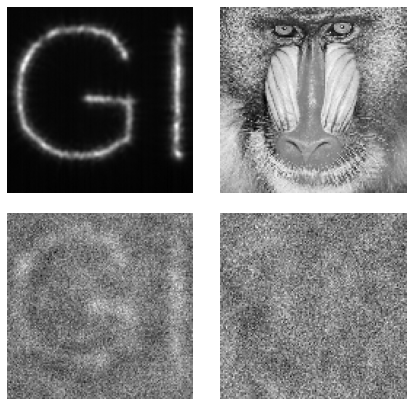

In [73]:
plt.figure(figsize=(7*3,2*3))
for j in range(total):   
    plt.subplot(2,7,j+1)
    plt.imshow(x_uu_list[j].cpu().numpy().reshape((Width,Height)),cmap="gray")
    plt.axis("off")
    
    plt.subplot(2,7,j+1+7)
    recv_img = recv_res[j]
    plt.imshow(recv_img.cpu().numpy().reshape((Width,Height)),cmap="gray")
    plt.axis("off")
plt.tight_layout(pad=2)
# plt.show()
# plt.savefig("{}/recv_res.jpg".format(root))